In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import albumentations as A

import itertools
import os
import glob
import time
import csv
import math

# Imaage imports
import imageio
from PIL import Image
from IPython.display import Image
from IPython import display
from pathlib import Path
import matplotlib.pyplot as plt
import cv2  

# Interpolation
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from tqdm.notebook import trange  # Progress bar
from tqdm.notebook import tqdm

import pydicom
from dicom_contour.contour import *
from evan_dicom_05_13 import *

#from contour import *


## Note, recursive search is slow for the dose and 

In [2]:
def load_arrays(data_path, dicom_type):
    """Load CT, RD, RS, RP file_paths"""
    files = sorted([path for path in glob.glob(f'{data_path}**/*{dicom_type}**/*.npy', recursive = True)])
    return files

def normalize_img(img):
    img = ((img - np.min(img)) / np.max(img) * 255)
    return img

def get_target_folder(data_path, date, ID, ROI_name):
    """Load first PTV or Cord Contour set
    Return None if set not found"""    
    year_folders = os.listdir(data_path)
    year_folders = [os.path.join(data_path, f) for f in year_folders]
    
    target_folders = []
    for path in year_folders:
        for sub_f in os.listdir(path):
            if '_RTst_' in sub_f and ID in sub_f:
                RTst_folder = os.path.join(path, sub_f) + '/Contours/'
                contour_folders = os.listdir(RTst_folder)
                target_folder = None
                # Get only 1 contour set
                for contour_folder in contour_folders:
                    if ROI_name == contour_folder:
                        target_folder = os.path.join(RTst_folder, contour_folder)
                return target_folder
            
# ------------------------------------------------------------------------           
            
def view_CT(stack, index=0, start_with=0, cmap='gray'):
    stack = stack[index]
    sample_stack(stack, start_with=start_with, cmap=cmap)
    
def sample_stack(stack, start_with=0, rows=8, cols=8,  show_every=3, cmap='gray'):
    """Set Index to view which slice"""
    fig,ax = plt.subplots(rows,cols,figsize=[30,30])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=cmap)
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
    
# ------------------------------------------------------------------------
def view_dose(stack, index=0, start_with=0, cmap='coolwarm'):
    """Index: index of patient
        Start_with = slice num """
    stack = stack[index]
    dose_stack(stack, start_with=start_with, cmap=cmap)

def dose_stack(stack, start_with=0, rows=8, cols=8,  show_every=3, cmap='coolwarm'):
    """Set Index to view which slice"""
    stack_min = stack.min()
    stack_max = stack.max()
    fig,ax = plt.subplots(rows,cols,figsize=[30,30])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=cmap)
        # added
        temp = ax[int(i/rows), int(i% rows)].imshow(stack[ind], cmap = 'coolwarm', vmin=stack_min, vmax=stack_max)
        ax[int(i/rows),int(i % rows)].axis('off')
        # show colorbar
        plt.colorbar(temp, ax=ax[int(i/rows), int(i %rows)])
    plt.show()
# ------------------------------------------------------------------------

def load_3D_scans(path):
    """STRUCTURE SET: Returns 3D stack of files from list of 2D images in the file-path"""
    files = sorted([path for path in glob.glob(f'{path}**/*.npy')])
    files = [np.load(file) for file in reversed(files)]
    # files = [np.dstack(scans) for scans in files]
    return files




In [3]:
# Refactor to not get all the files in the "DOSE" folder because it gets all the numpy arrays
prep_data_path = '/data/users/chene/preprocessed/dose/'

# Get all dose file paths
dose_file_paths = load_arrays(prep_data_path, '_RTDOSE_')
dose_arrs = [np.load(file) for file in dose_file_paths]

# Get all CT file paths
CT_file_paths = load_arrays(prep_data_path, '_CT_') 
CT_arrs = [np.load(file) for file in CT_file_paths]

# Group list for 1:1 loading
grouped_CTs = [(file, image) for file, image in zip(CT_file_paths, CT_arrs)]

years = [path.split('/', 7)[6] for path in dose_file_paths]
folders = [path.split('/', 8)[7] for path in dose_file_paths]
locations = [year + '/' + folder for year, folder in zip(years, folders)]

# Get the contours of interest from the excel

# Create a column for the CT array and the dose array

In [4]:
df_contour = pd.read_csv('May.csv', dtype='object')
df_contour = df_contour.drop(index=0)

# Replace space with _ for "PTV" and "Cord Structure" elements
df_contour['PTV'] = df_contour['PTV'].apply(lambda x: x.replace(" ", "_"))
df_contour['Cord Structure'] = df_contour['Cord Structure'].apply(lambda x: str(x).replace(" ", "_"))

# Get the index of the patient that has the unique identifier in the pathname
id_nums = df_contour.ID.values
dates = df_contour.date.values


matched_CT_path = [None] * len(df_contour)
matched_CT_arr = [None] * len(df_contour)

matched_dose_paths = []
matched_dose_arrs = []

matched_RTst = []

dose_path_1 = [None] * len(df_contour)
dose_path_2 = [None] * len(df_contour)
dose_path_3 = [None] * len(df_contour)

dose_1 = [None] * len(df_contour)    
dose_2 = [None] * len(df_contour)   # If there are 2 RT_DOSE
dose_3 = [None] * len(df_contour)   # If there are 3 RT_DOSE


for i, (num, date) in enumerate(zip(id_nums, dates)):
    
    # get related CTs 
    for path, CT_arr in zip(CT_file_paths, CT_arrs):
        if num in path and date in path:
            matched_CT_path[i] = path
            matched_CT_arr[i] = CT_arr

    # Get Related Doses
    dose_paths = [path for path, dose_arr in zip(dose_file_paths, dose_arrs) if num in path and date in path]
    dose_image = [dose_arr for path, dose_arr in zip(dose_file_paths, dose_arrs) if num in path and date in path]
    matched_dose_paths.append(dose_paths)
    matched_dose_arrs.append(dose_image)

# Dose 1, Dose 2, Dose 3      
for idx, (path_list, image_list) in enumerate(zip(matched_dose_paths, matched_dose_arrs)):
    if len(path_list) == 0:
        continue
        
    elif len(path_list) > 0:
        dose_path_1[idx] = path_list[0]
        dose_1[idx] = image_list[0]
        
        if len(path_list) >1:
            dose_path_2[idx] = path_list[1]
            dose_2[idx] = image_list[1]
            
            if len(path_list) >2:
                dose_path_3[idx] = path_list[2]
                dose_3[idx] = image_list[2]
            else: 
                continue
        else:
            continue
        
df_contour['CT_path'] = matched_CT_path
df_contour['dose_path_1'] = dose_path_1
df_contour['dose_path_2'] = dose_path_2
df_contour['dose_path_3'] = dose_path_3


# df_contour["CT_arr"] = matched_CT_arr
# df_contour['dose_1'] = dose_1
# df_contour['dose_2'] = dose_2
# df_contour['dose_3'] = dose_3


df_contour.head(8)

ID     date Dose Location          Shape                  PTV  \
1  66006310  2021-03  NaN   Lspine           body            d_PTVeval   
2  10038707  2021-04  NaN   Tspine  body, L trans                  PTV   
3  51039203  2020-10  NaN   Tspine           body        PTV_T4_3000^5   
4  62715782  2021-02  NaN   Tspine           body              PTV_T11   
5  63945854  2021-02  NaN   Lspine           body  PTV_L1_30Gy_in_3_fx   
6  60988501  2020-09  NaN   Lspine           body              PTV1_L1   
7  60291667  2019-03  NaN   Lspine           body               PTV_L2   
8  60291667  2019-03  NaN   Tspine           body           PTV_T11-12   

  Cord Structure Cord in PTV?                             Notes Unnamed: 9  \
1    SpinalCanal            0                              GOOD         Tr   
2     SpinalCord            0                              GOOD         Tr   
3     SpinalCord            0  cord is also target, might work…         Tr   
4    Canal_Spine            0                              GOOD         Tr   
5    Spinal_cord            0                              GOOD         Tr   
6     SpinalCord            0                              GOOD         Tr   
7          Canal            0                     1 level, GOOD         Tr   
8     SpinalCord            0                     2 level, GOOD         Tr   

                                             CT_path  \
1  /data/users/chene/preprocessed/dose/2021-03__S...   
2                                               None   
3  /data/users/chene/preprocessed/dose/2020-10__S...   
4                                               None   
5                                               None   
6  /data/users/chene/preprocessed/dose/2020-09__S...   
7  /data/users/chene/preprocessed/dose/2019-03__S...   
8  /data/users/chene/preprocessed/dose/2019-03__S...   

                                         dose_path_1 dose_path_2 dose_path_3  
1  /data/users/chene/preprocessed/dose/2021-03__S...        None        None  
2                                               None        None        None  
3  /data/users/chene/preprocessed/dose/2020-10__S...        None        None  
4                                               None        None        None  
5                                               None        None        None  
6  /data/users/chene/preprocessed/dose/2020-09__S...        None        None  
7                                               None        None        None  
8                                               None        None        None

# Grab RTst files

In [5]:
def get_folders(data_path):
    folders = os.listdir(data_path)
    # folders.remove('.DS_Store')
    folders.sort()
    return folders


data_path = '/data/users/chene/052021_data/May_Data_Dump/'
folders = get_folders(data_path)
abs_paths = [data_path + folder for folder in folders] 

# Get all subdirectories 
subdir_names, subdir_paths = [], []
for folder, path in zip(folders, abs_paths):
    sub_dirs = os.listdir(path)
    subdir_names.extend(sub_dirs)
    
    #Get full paths
    sub_paths = [os.path.join(path, sub_dir) for sub_dir in sub_dirs]
    subdir_paths.extend(sub_paths)


CT_folder_paths = [path for path in subdir_paths if '_CT_' in path]
DOSE_folder_paths = [path for path in subdir_paths if '_RTDOSE_' in path]
RTst_folder_paths = [path for path in subdir_paths if '_RTst_' in path]
RTPLAN_folder_paths = [path for path in subdir_paths if '_RTPLAN_' in path]

all_rt_doses = load_dicoms(data_path, dicom_type = '_RTDOSE_')
all_RTst = load_dicoms(data_path, dicom_type = '_RTst_')
all_RTplans = load_dicoms(data_path, dicom_type = '_RTPLAN_')

len(all_rt_doses), len(all_RTst), len(all_RTplans)

(46, 44, 46)

# Get matched RTst_file

In [6]:
matched_RTst_file = [None] * len(df_contour)
matched_dose_file = [None] * len(df_contour)

for i, (num, date) in enumerate(zip(id_nums, dates)):
    
    # get related CTs 
    for file in all_RTst:
        if num in file and date in file:
            matched_RTst_file[i] = file   
    for file in all_rt_doses:
        if num in file and date in file:
            matched_dose_file[i] = file   

df_contour['RTst_file'] = matched_RTst_file


# Grab the PTV and Cord Contour file paths

In [7]:
# Get the target PTV Contours
target_PTVs = df_contour.PTV.values
target_PTVs = [PTV.upper() for PTV in target_PTVs]

# Get the target Cord Contours
target_cords = df_contour['Cord Structure'].values
target_cords = [cord.upper() for cord in target_cords]


# Get target PTV folder paths
PTV_paths = []
for date, ID, PTV in zip(dates, id_nums, target_PTVs):
    PTV_paths.append(get_target_folder(prep_data_path, date, ID, PTV))
    
# Get target Cord folder paths                
cord_paths = []     
for date, ID, PTV in zip(dates, id_nums, target_cords):
    cord_paths.append(get_target_folder(prep_data_path, date, ID, PTV))
    
# Add to DF  
df_contour['PTV_path'] = PTV_paths 
df_contour['cord_path'] = cord_paths

# Match starting index from PTV and Contour arrays by comparing with CT

In [8]:
def align_contour_CT(img_arrs, matched_CT_arr):
    """Returns contour slice indexes from CT in order to show CT and interpolated
    dose frames that contain the PTV/cord contours"""
    
    indexes = [None] * len(img_arrs)
    for i, (PTV, CT) in enumerate(zip(img_arrs, matched_CT_arr)):
        if (PTV !=None) and  isinstance(CT, np.ndarray):
            CT_slices = [] 
            for idx_1, img_1 in enumerate(PTV):
                for idx_2, img_2 in enumerate(CT):
                    if np.array_equal(img_1, img_2):
                        CT_slices.append(idx_2)
                        break
            indexes[i] = CT_slices
        else:
            continue

    return indexes

In [9]:
# Get Paths to Contour and image arrays
PTV_contour_paths = [f + '/Contour_arr' if f!= None else None for f in PTV_paths]
PTV_image_paths = [f + '/Image_arr'     if f!= None else None for f in PTV_paths]
df_contour['PTV_contour_path'] = PTV_contour_paths
df_contour['PTV_image_path'] = PTV_image_paths

# list of CORD 3D contours and image arr 
Cord_contour_paths = [f + '/Contour_arr' if f!= None else None for f in cord_paths ]
Cord_image_paths = [f + '/Image_arr' if f!= None else None for f in cord_paths]
df_contour['Cord_contour_path'] = Cord_contour_paths
df_contour['Cord_image_path'] = Cord_image_paths


# Load 3D np array of PTV contours and related CT scans
PTV_contour_arrs = [load_3D_scans(path)if path!= None else None for path in PTV_contour_paths]
PTV_image_arrs = [load_3D_scans(path)    if path!= None else None for path in PTV_image_paths ]

# Load 3D np array of PTV contours and related CT scans
Cord_contour_arrs = [load_3D_scans(path) if path!= None else None for path in Cord_contour_paths]
Cord_image_arrs = [load_3D_scans(path) if path!= None else None for path in Cord_image_paths]

# Call Above function to align the indexes of each PTV and Cord
PTV_indexes = align_contour_CT(PTV_image_arrs, matched_CT_arr)
cord_indexes = align_contour_CT(Cord_image_arrs, matched_CT_arr)

# Add to DF  
df_contour['PTV_indices'] = PTV_indexes
df_contour['Cord_indices'] = cord_indexes

# Watch out for NoneType Objects

In [10]:
df_contour.Cord_indices

1     [67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 7...
2                                                  None
3                                                  None
4                                                  None
5                                                  None
6                                                  None
7                                                  None
8                                                  None
9                                                  None
10                                                 None
11                                                 None
12                                                 None
13                                                 None
14                                                 None
15    [315, 314, 313, 312, 311, 310, 309, 308, 307, ...
16    [281, 280, 279, 278, 277, 276, 275, 274, 273, ...
17    [167, 168, 169, 170, 171, 172, 173, 174, 175, ...
18                                              

In [11]:
# no dose
no_dose = []
for i, (a, b, c) in enumerate(zip(dose_1, matched_CT_arr, PTV_paths)):
    if a is None:
        no_dose.append(i)

# Missing CT 
no_CT = []
for i, (a, b, c) in enumerate(zip(dose_1, matched_CT_arr, PTV_paths)):
    if b is None:
        no_CT.append(i)

# no PTV_path
no_PTV_path = []
for i, (a, b, c) in enumerate(zip(dose_1, matched_CT_arr, PTV_paths)):
    if c is None:
        no_PTV_path.append(i)  
print("NO DOSE:", no_dose)
print("NO CT:", no_CT)
print("NO PTV PATH:", no_PTV_path)

NO DOSE: [1, 3, 4, 6, 7, 8, 9, 12, 13, 26, 28, 38]
NO CT: [1, 3, 4, 12, 13, 28]
NO PTV PATH: [5, 6, 7, 8, 9, 10, 12, 21, 22, 24, 26, 28, 29, 30, 35, 37, 38]


In [12]:
for x in no_PTV_path:
    patient_id = df_contour.iloc[x].ID
    date = df_contour.iloc[x].date
    target_PTV = df_contour.iloc[x].PTV
    print(patient_id, date, target_PTV)
    

60988501 2020-09 PTV1_L1
60291667 2019-03 PTV_L2
60291667 2019-03 PTV_T11-12
60291667 2019-03 PTV_T9
7672373 2020-02 PTV_T4_eval
396303 2021-03 PTV_L5
12355645 2021-03 PTV
58338931 2018-10 D_PTV_L3
61962204 2018-09 D_PTV_L3
66235645 2019-01 PTVeval=ptv-spinacanal5mm
66783251 2020-11 PTV_L3_18Gy_3fx
78526130 2020-08 PTV
69698298 2020-06 PTV_L5
69698298 2020-08 d_opt35
50602109 2021-03 d_evalPTV_L2
57458763 2019-01 PTV_20Gy_5Fx
51972953 2020-08 PTVeval_PTV_T1-T2


In [13]:
print("NO DOSE: \n",  df_contour.iloc[no_dose]['ID'].values)
print("NO CT: \n", df_contour.iloc[no_CT]['ID'].values)
print("NO PTV_PATH: \n", df_contour.iloc[no_PTV_path]['ID'].values)

NO DOSE: 
 ['10038707' '62715782' '63945854' '60291667' '60291667' '60291667'
 '7672373' '12355645' '60949743' '66783251' '78526130' '51972953']
NO CT: 
 ['10038707' '62715782' '63945854' '12355645' '60949743' '78526130']
NO PTV_PATH: 
 ['60988501' '60291667' '60291667' '60291667' '7672373' '396303' '12355645'
 '58338931' '61962204' '66235645' '66783251' '78526130' '69698298'
 '69698298' '50602109' '57458763' '51972953']


# Show Contours only on the PTV_indexes

In [14]:
# Get patients with more than 1 dose array
dose_2_indexes = df_contour[df_contour['dose_path_2'].notnull()].index.tolist()
dose_3_indexes = df_contour[df_contour['dose_path_3'].notnull()].index.tolist()


In [15]:
def overlay_contour(i, indices, img_arrs, contour_arrs, dose):
    """Grabs the proper frames from the dose array 
        i = patient row"""
    CTs = img_arrs[i]     # equivalent to CT
    contours = contour_arrs[i]
    
    # global dose normalization
    dose_min = dose[i].min()
    dose_max = dose[i].max()
    print(dose_min, dose_max)
    
    mapping = indices[i] # Get dose frame indices
    patient_dose = dose[i]
    dose_frames = [patient_dose[i] for i in mapping] # grabs the proper frames from the dose array 
    
    for slice_num, CT, contour, dose in zip(mapping, CTs, contours, dose_frames):
        
        # create mask
        mask = np.ma.masked_where(contour == 0, contour)
        # mask = fill_contours(contour)
        # Show CT contour
        plt.figure(figsize= (20,20))
        plt.subplot(1, 2, 1)
        plt.imshow(CT, cmap='gray', interpolation='none')
        plt.imshow(mask, cmap='cool', interpolation='none', alpha=0.7)
        
        # Show dose contour overlay
        plt.subplot(1, 2, 2)
        plt.imshow(dose, cmap='coolwarm', interpolation='none', vmin=dose_min, vmax=dose_max)
        plt.imshow(mask, cmap='cool', interpolation='none', alpha=0.7)
        plt.show()

0.0 65478.34771185998


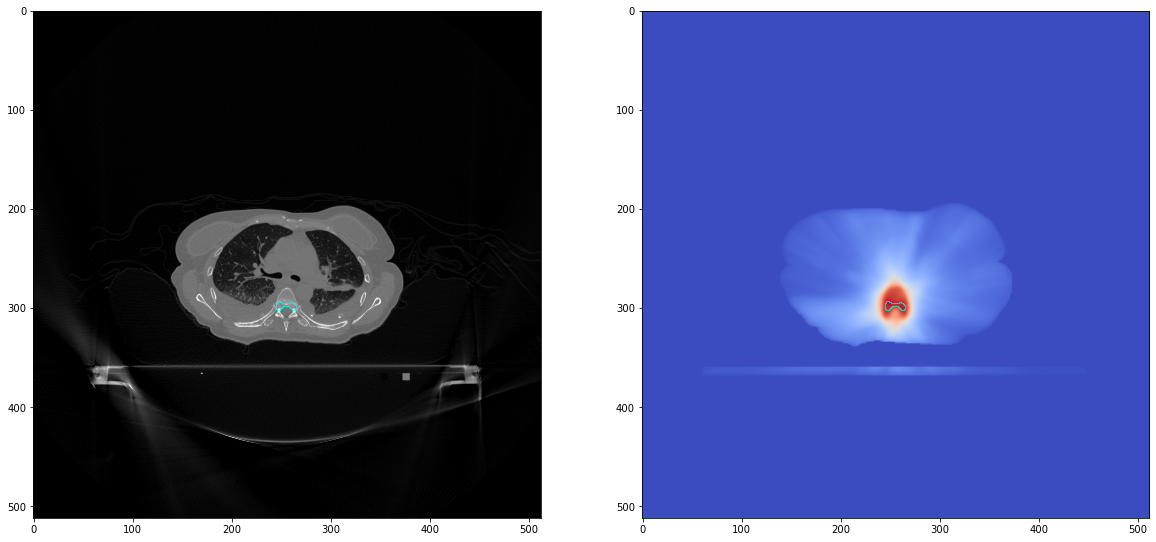

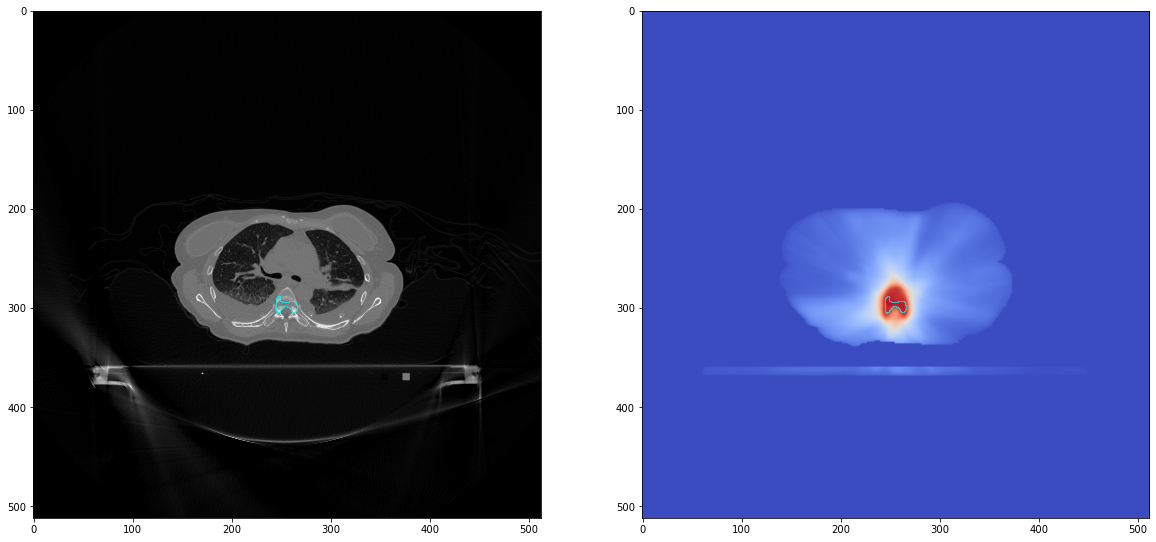

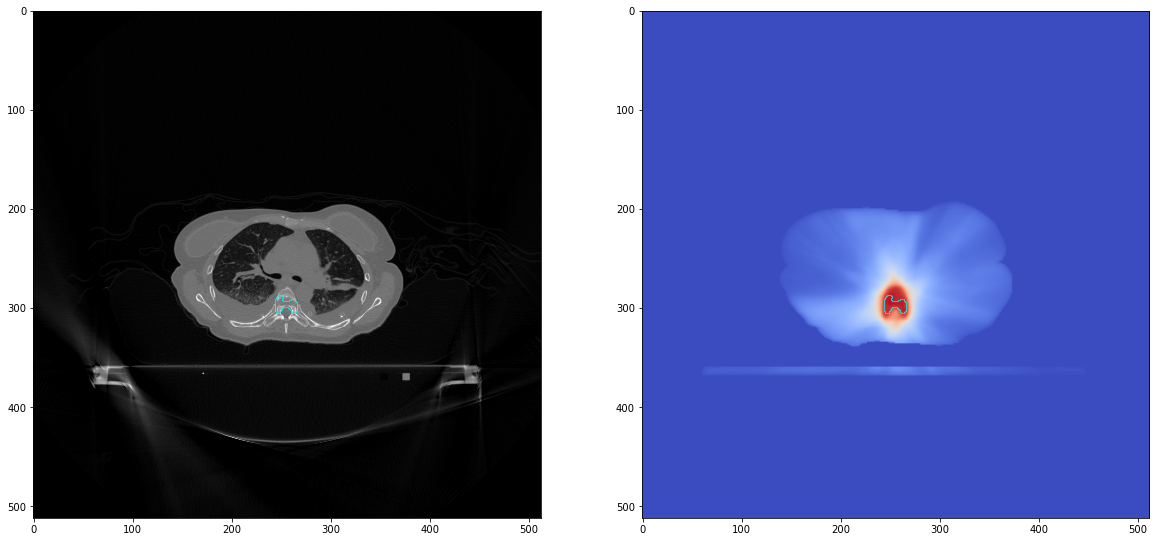

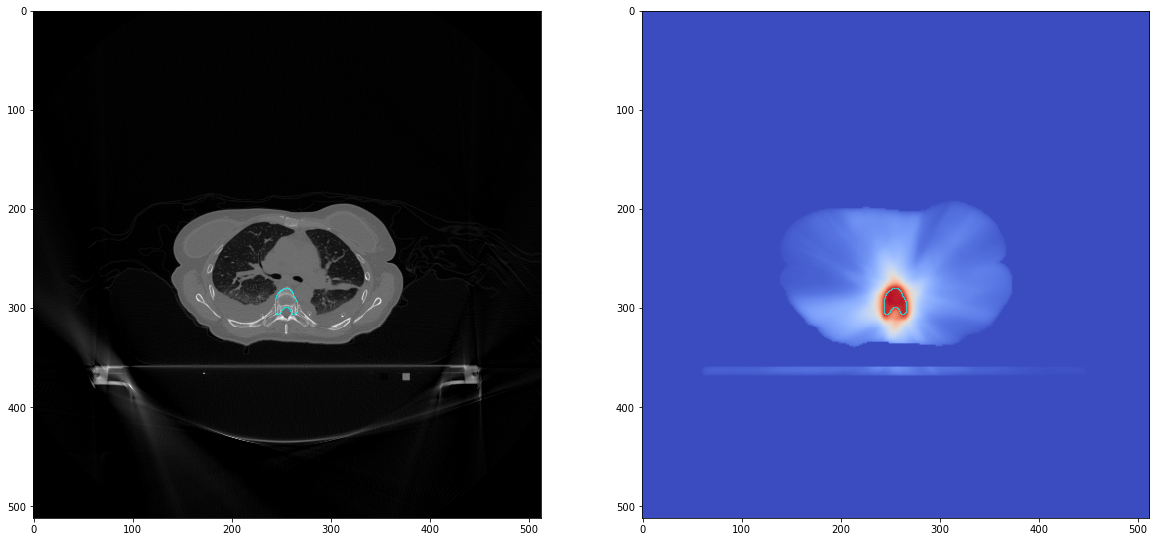

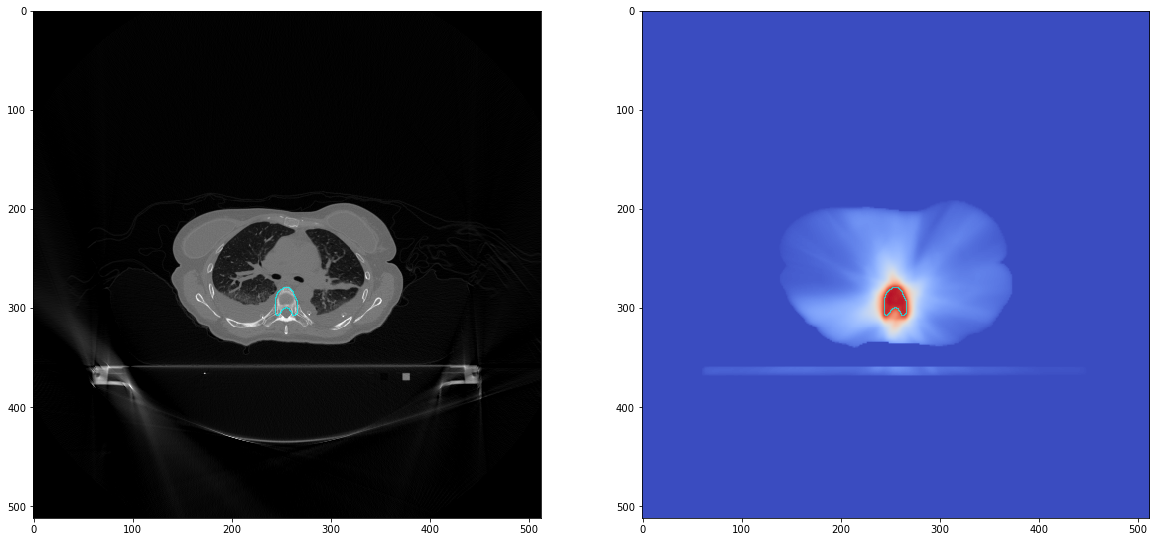

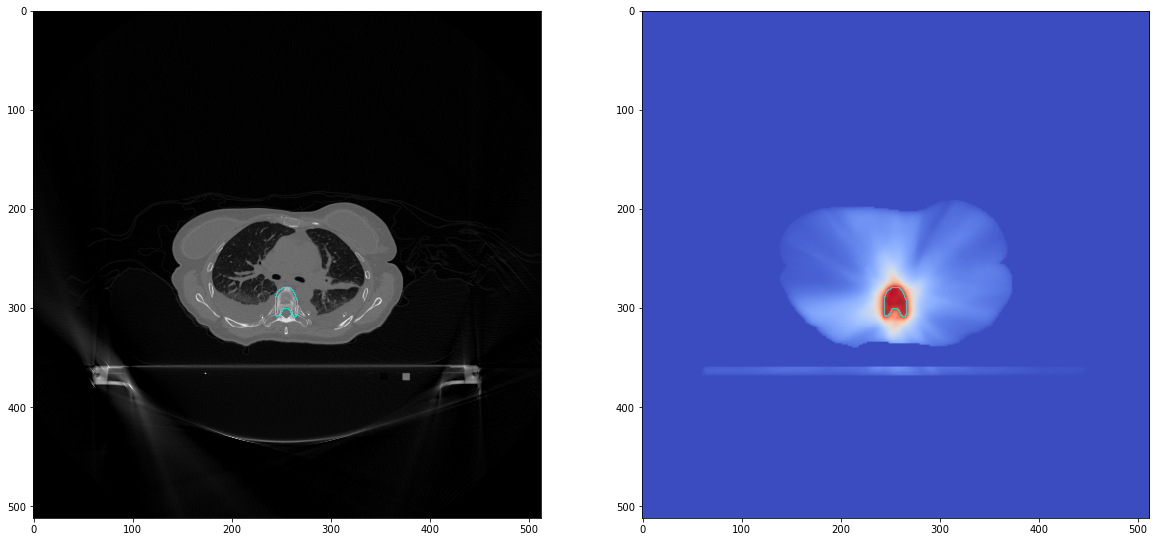

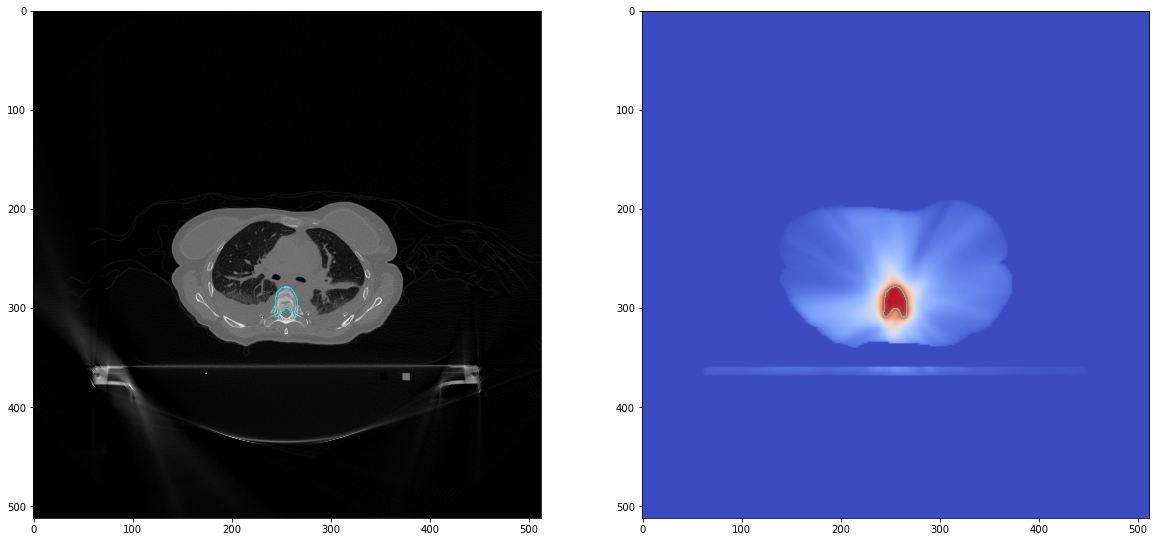

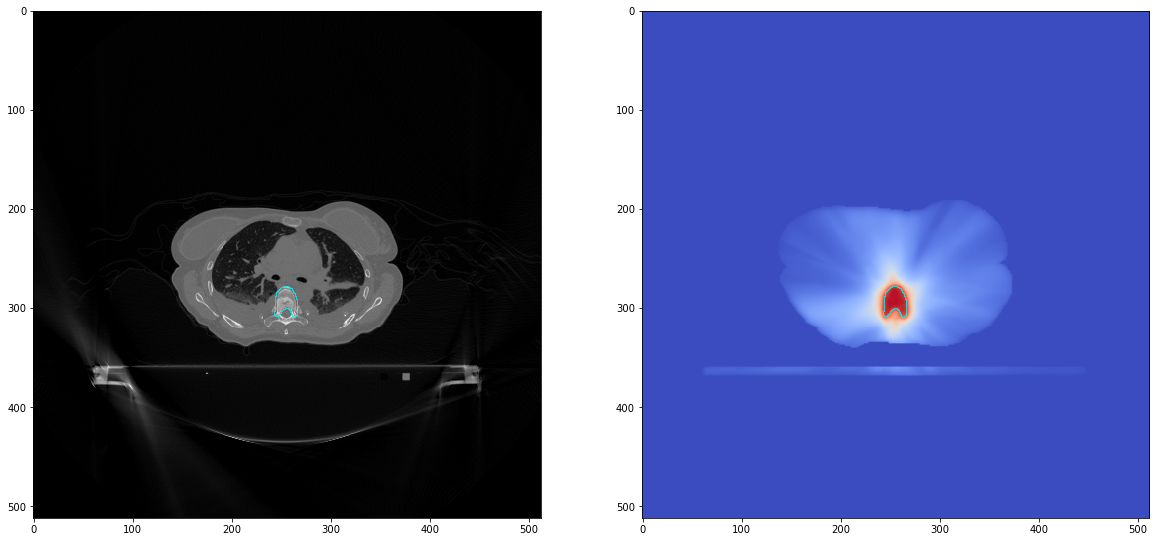

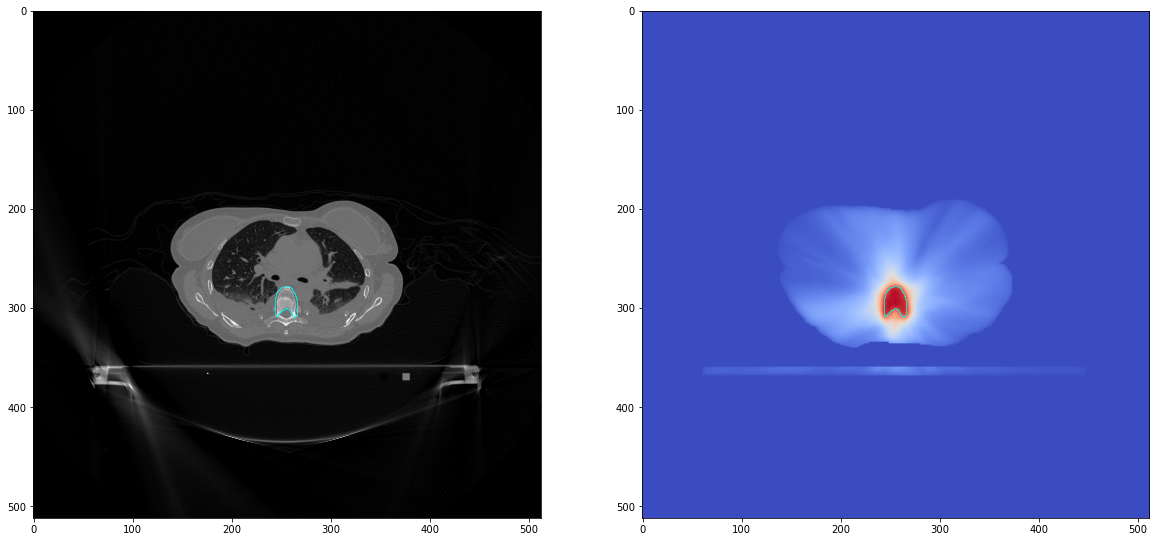

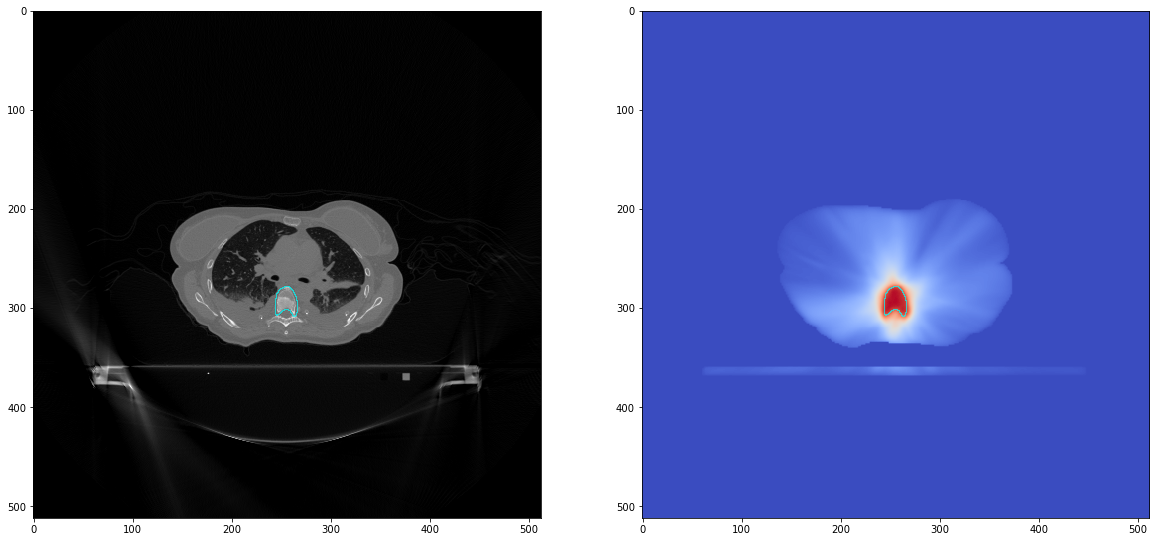

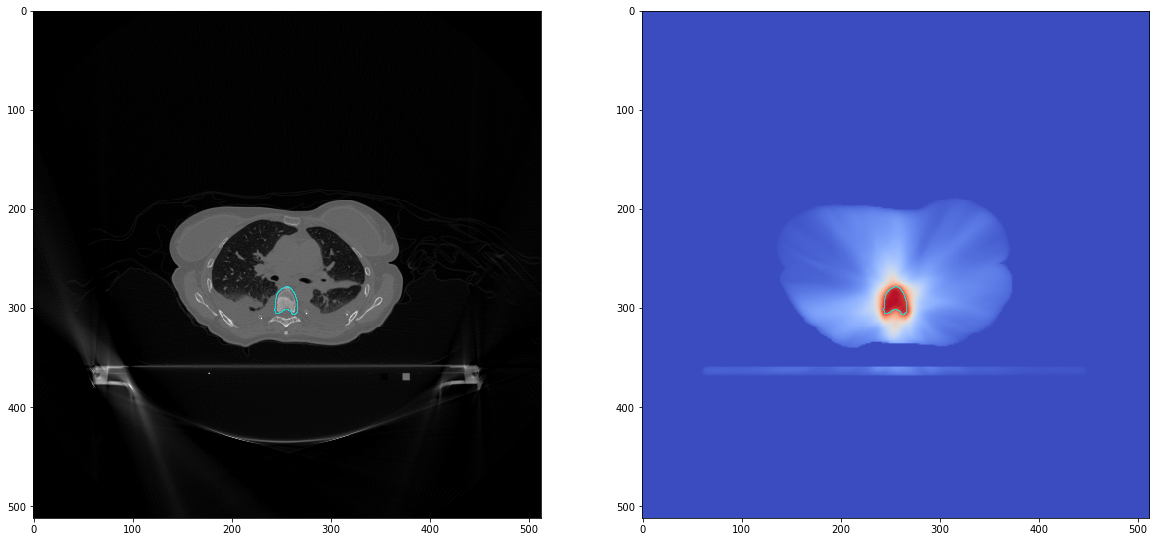

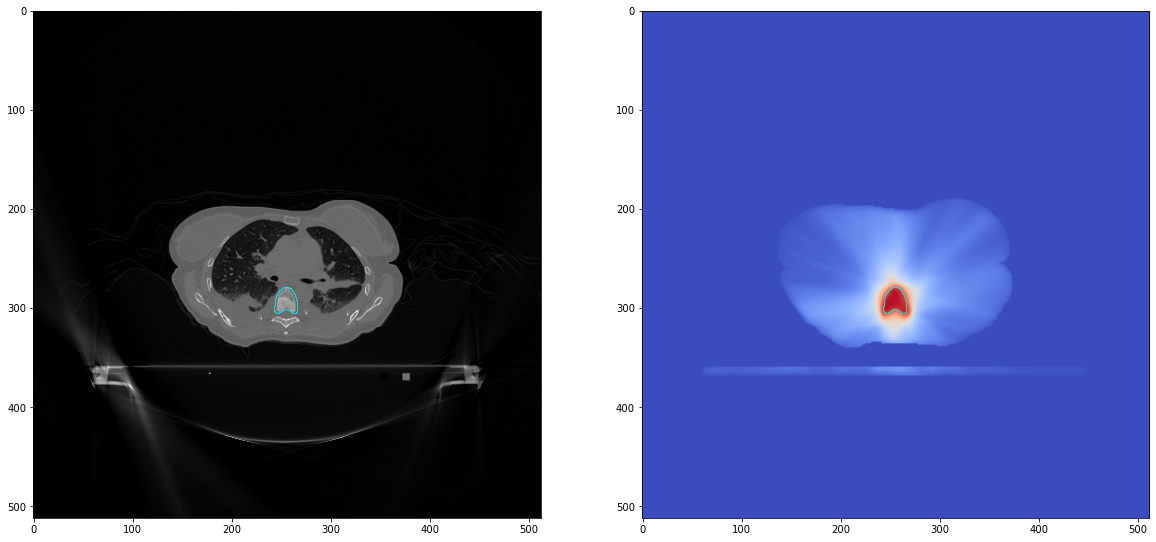

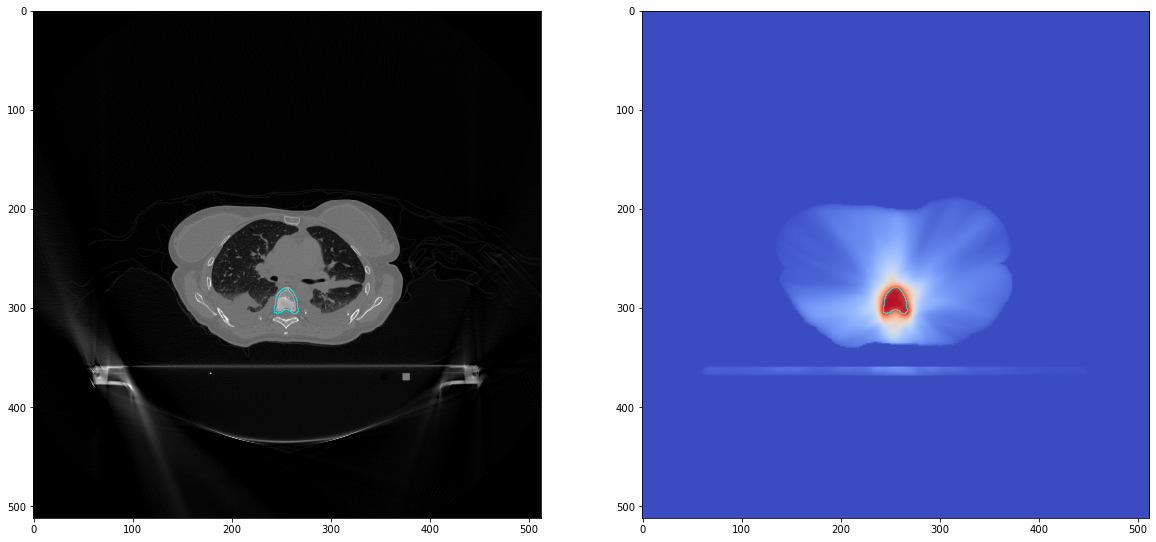

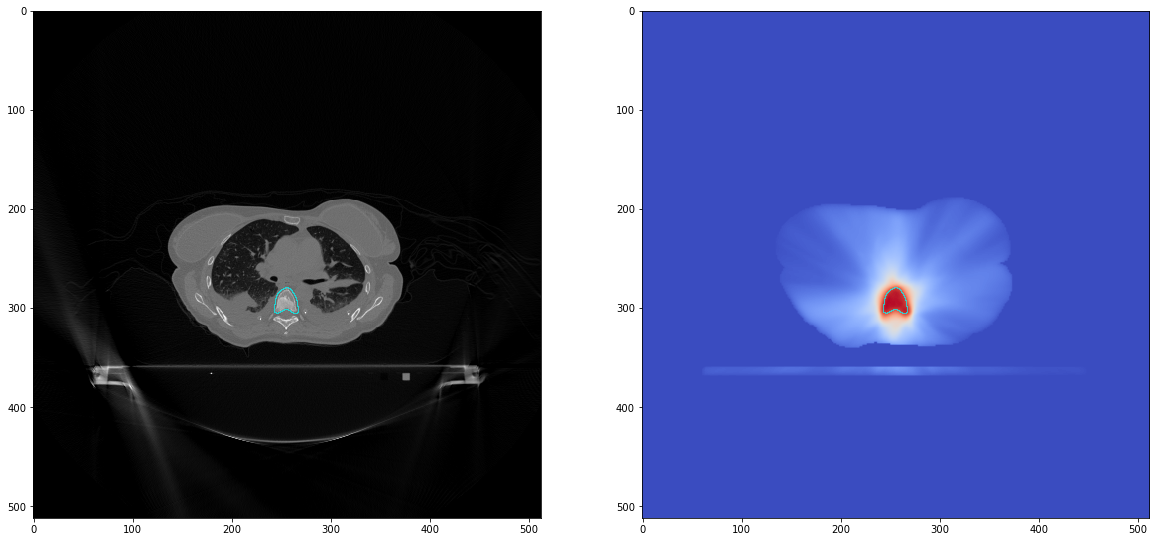

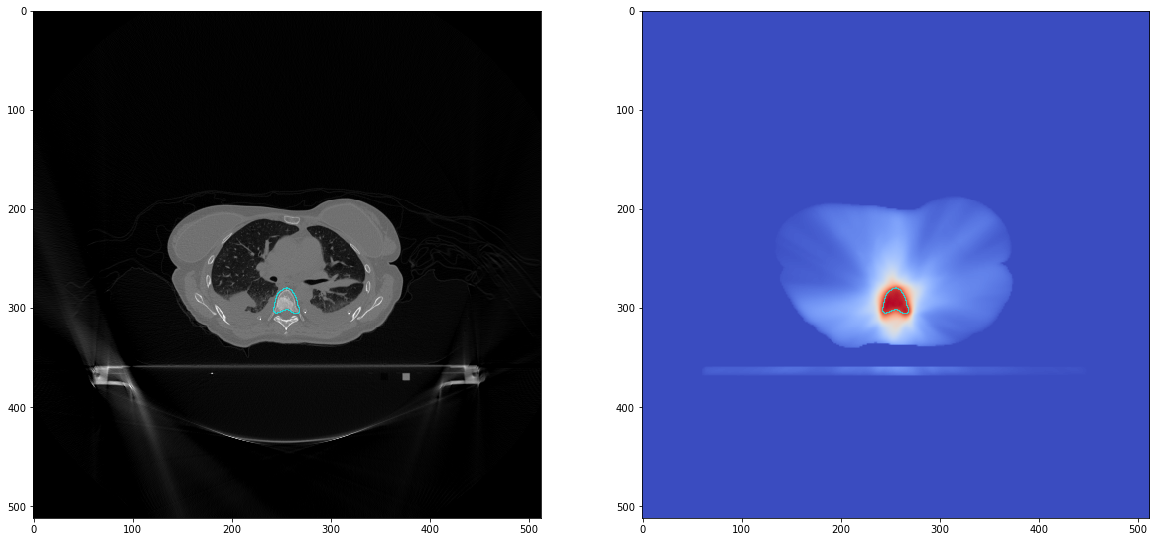

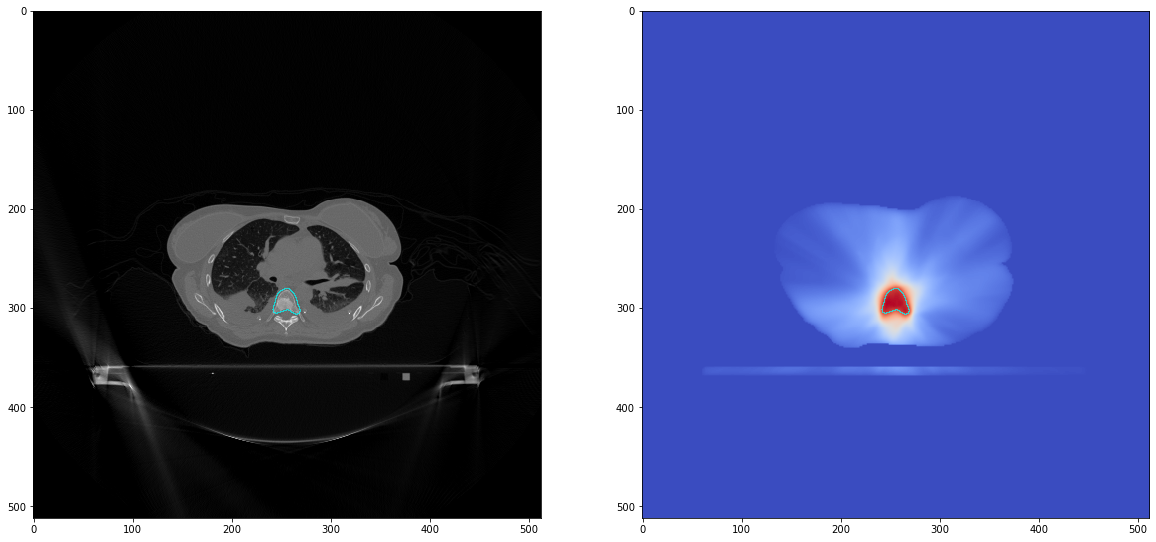

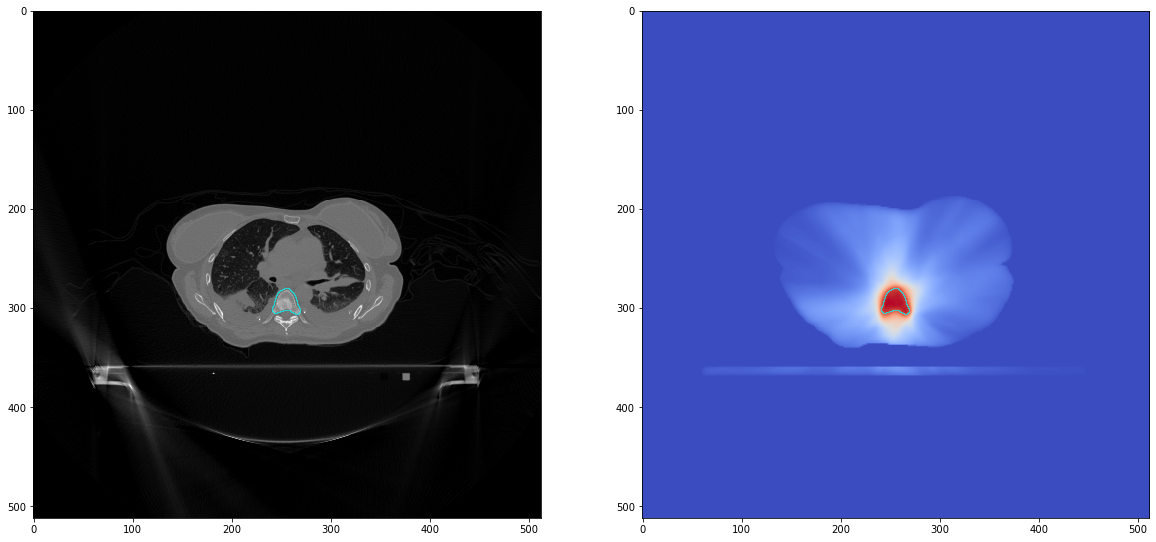

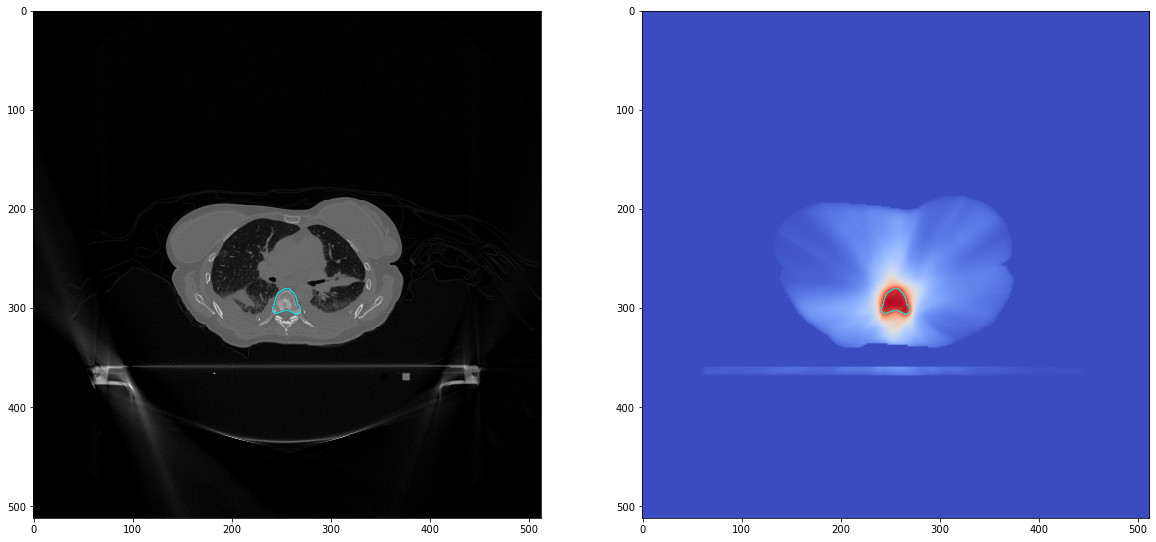

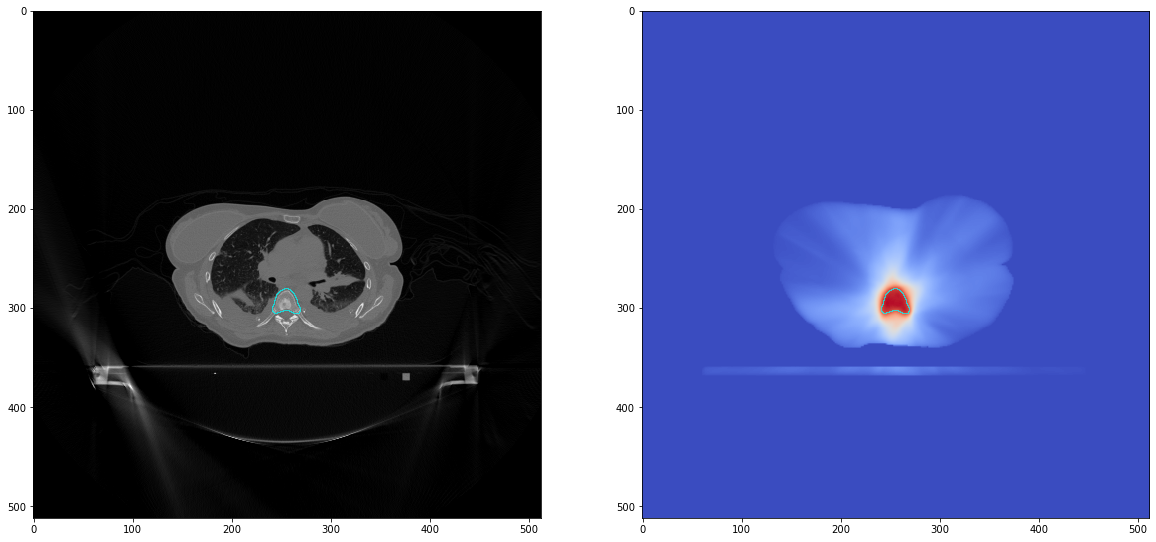

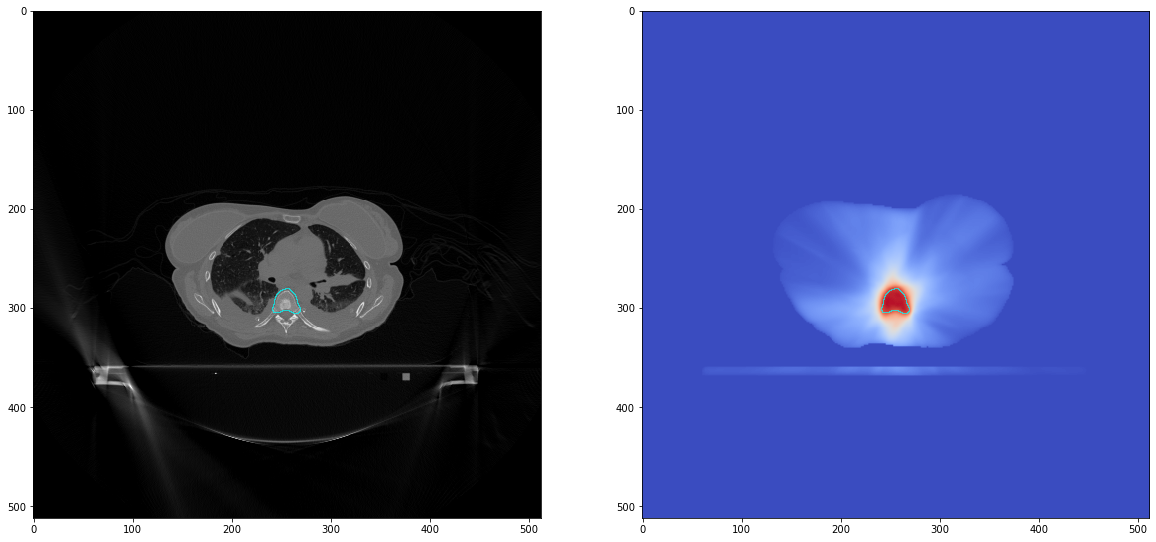

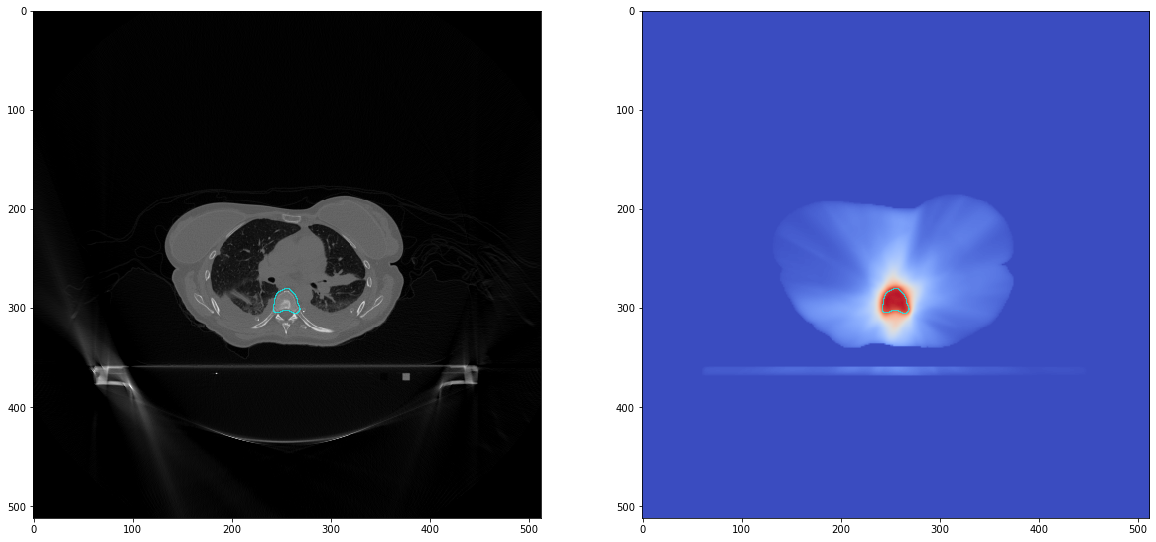

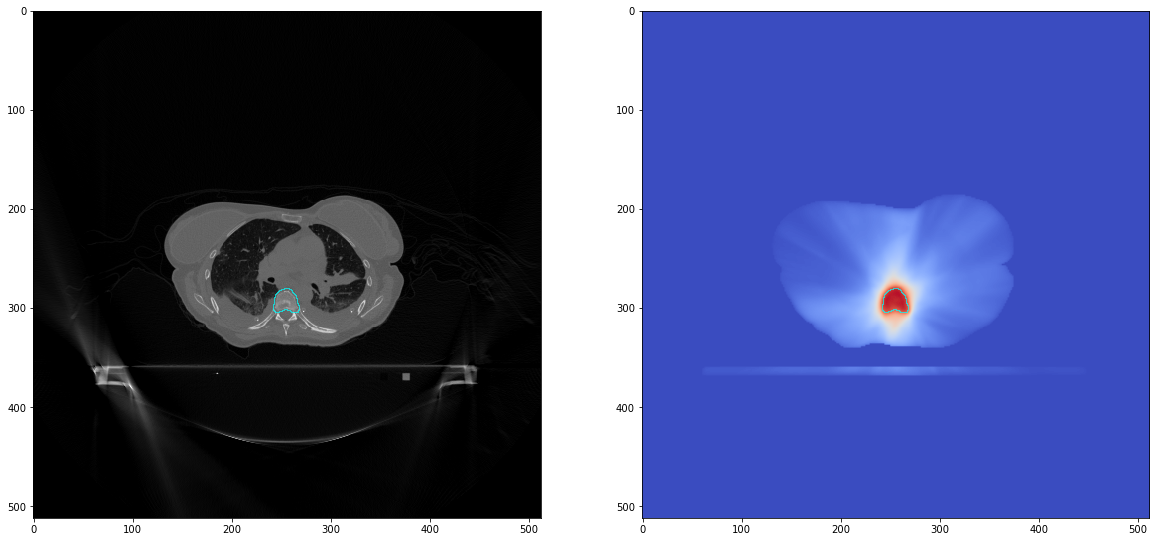

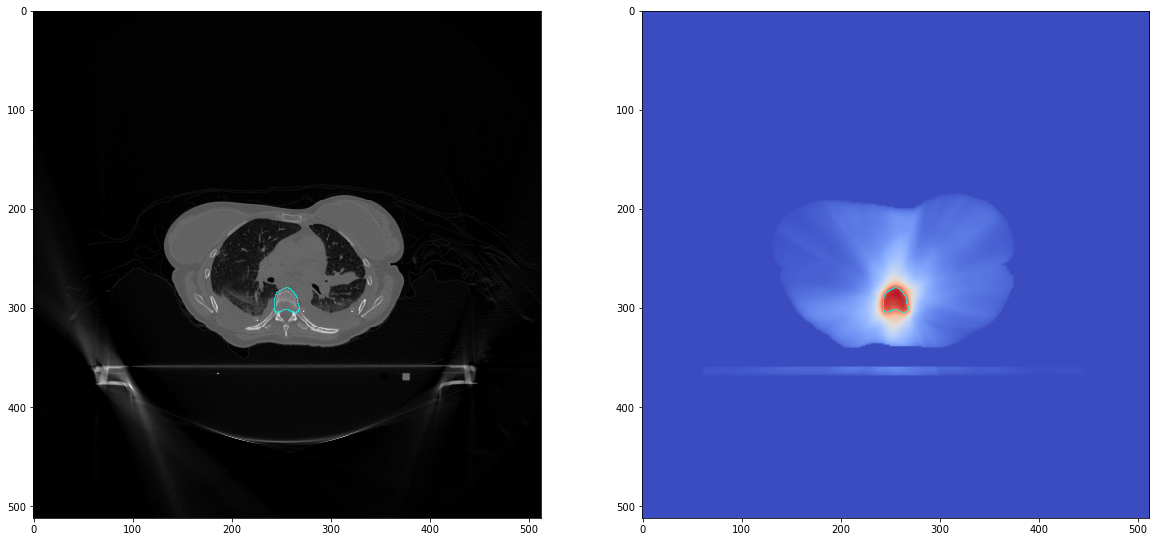

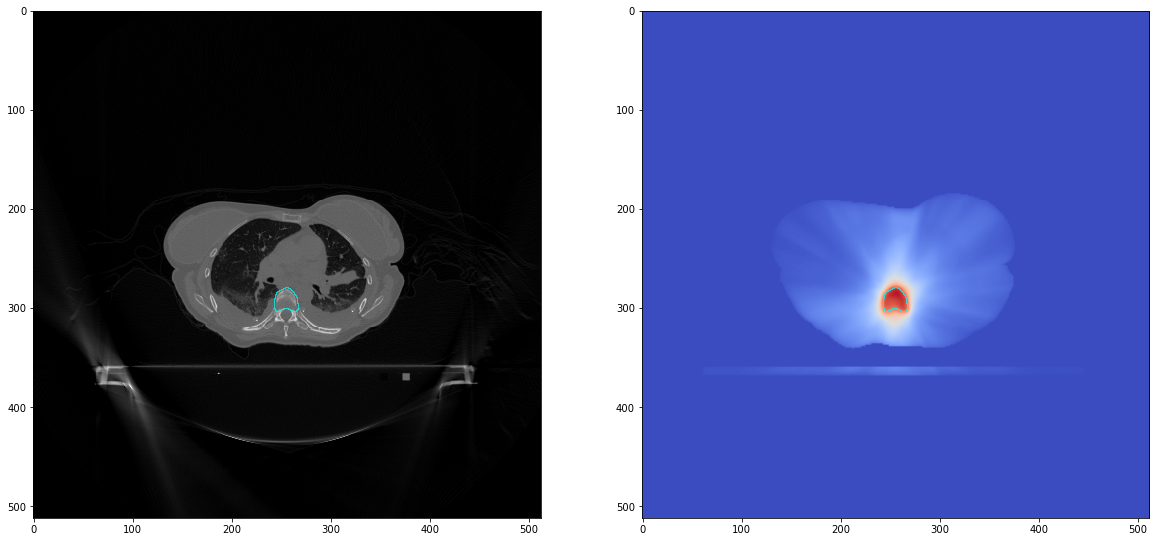

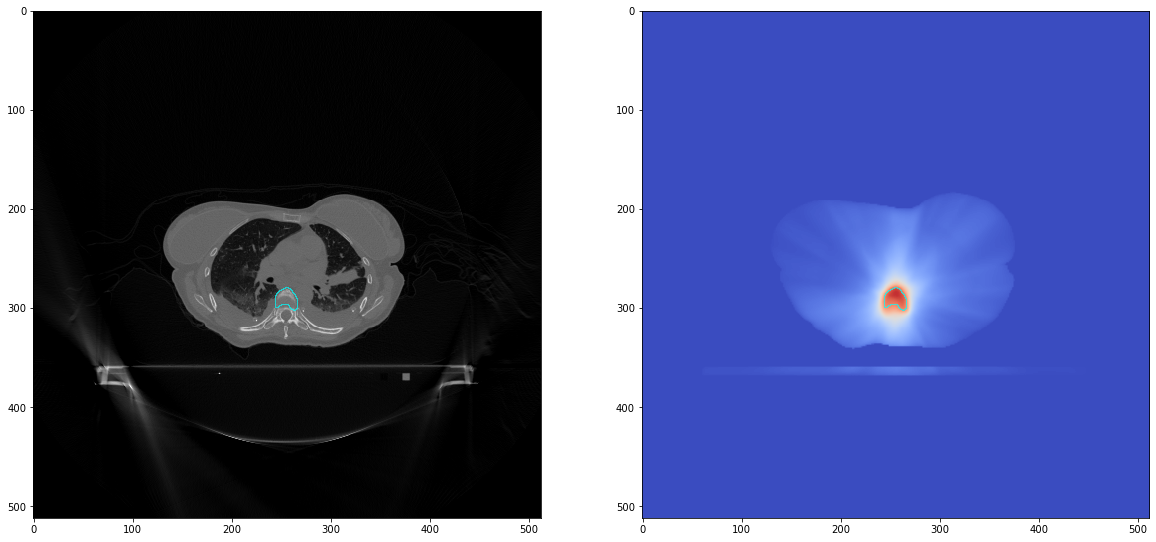

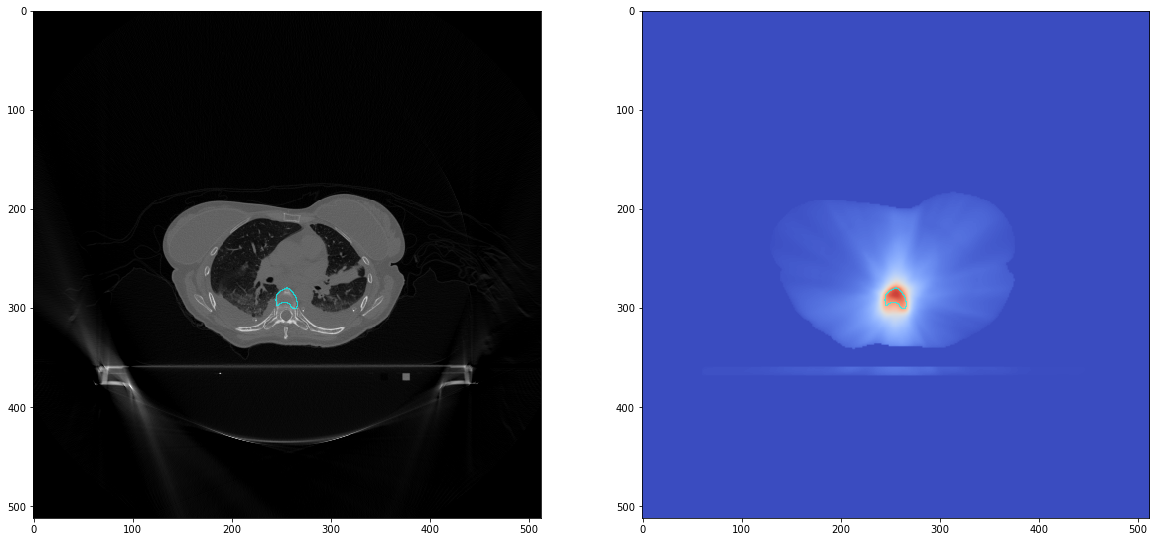

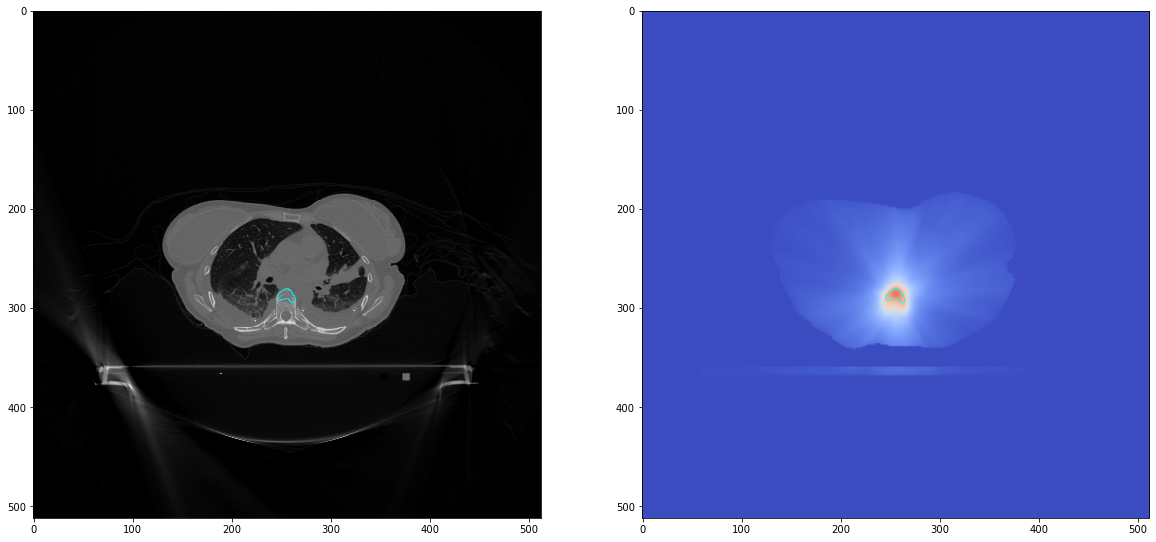

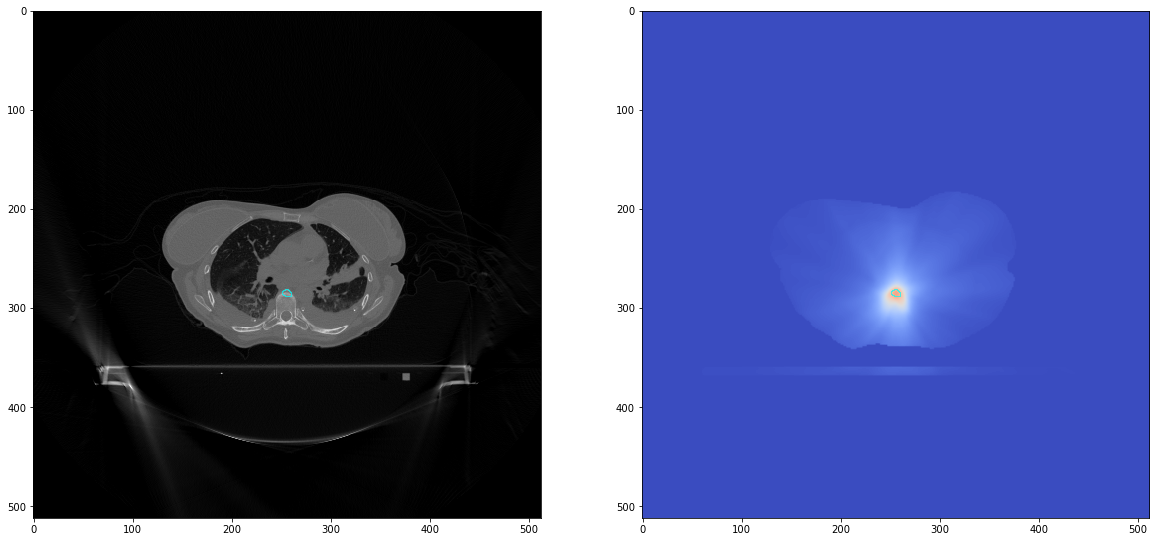

In [16]:
overlay_contour(45, PTV_indexes, PTV_image_arrs, PTV_contour_arrs, dose_1)


In [17]:
# DF indexes with good doses
# 19, 20 a little weird; 46 shows up but the PTV is off
good_dose_1 = [0, 2, 14, 16, 17, 18, 19, 20, 25, 27, 31, 32, 33, 34, 36, 39, 40, 41, 42, 43, 44, 45]

# DF indexes with awry overlay
others = [num for num in range(0,47) if num not in good_dose_1]
issue_IDs = df_contour.iloc[others]['ID'].values

print(issue_IDs)
print(len(good_dose_1))
print(others)

['10038707' '62715782' '63945854' '60988501' '60291667' '60291667'
 '60291667' '7672373' '396303' '396303' '12355645' '60949743' '81273898'
 '58338931' '61962204' '61962204' '66235645' '66783251' '78526130'
 '69698298' '69698298' '50602109' '57458763' '51972953' '75988141']
22
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 26, 28, 29, 30, 35, 37, 38, 46]


## Examine problem folders

In [18]:
for i in others:
    print('DF INDEX:', i, '\n PTV Idexes:', PTV_indexes[i])
    print('Cord Indexes:', cord_indexes[i], '\n')
    # print(cord_indexes[i])

DF INDEX: 1 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 3 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 4 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 5 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 6 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 7 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 8 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 9 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 10 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 11 
 PTV Idexes: []
Cord Indexes: None 

DF INDEX: 12 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 13 
 PTV Idexes: None
Cord Indexes: None 

DF INDEX: 15 
 PTV Idexes: [255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214]
Cord Indexes: [281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 2

# Create a traning DF

In [19]:
# Consolidate good dose_arrays 
target_dose_paths = [None] * len(df_contour)

for i in good_dose_1:
    target_dose_paths[i] = df_contour.iloc[i]['dose_path_1']
df_contour['np_dose_path'] = target_dose_paths

# Take only the good rows
df_train = df_contour.iloc[good_dose_1]
df_train = df_train.drop(columns = ['dose_path_1', 'dose_path_2', 'dose_path_3'])


# Get original matching dose file (uninterpolated)
# IMPORTANT: Because the directory structure was not saved to include the second unique identifier, the matched_dose_paths are appending 2 
- Not applicable for May Dataset as it is 1-1 

In [20]:
# all_rt_doses = load_dicoms(data_path, dicom_type = '_RTDOSE_')

# dose_file_nums = [file.rsplit('/')[-1] for file in df_train['np_dose_path'].values]
# dose_file_nums = [s.split('.')[0] for s in dose_file_nums]

# dose_file_identifier = [file.split('/', 6)[-1] for file in df_train['np_dose_path'].values]
# dose_file_identifier = [s.rsplit('/',1)[0] for s in dose_file_identifier]

# unique_IDs = df_train['ID'].values
# dates = df_train['date'].values

# matched_dose_paths = []
# double_matched = []
# for (identifier, dose_num) in zip(dose_file_identifier, dose_file_nums):
#     counter = 0
#     for path in all_rt_doses:
#         if identifier in path and dose_num in path:
#             matched_dose_paths.append(path)
#             if '52970253' not in identifier:
#                 all_rt_doses.remove(path)
#             counter +=1
            
#     if counter ==2:
#         double_matched.append(matched_dose_paths[-1])
#         double_matched.append(matched_dose_paths[-2])

            
# # NOTE: 
# print(len(matched_dose_paths))
# # double_matched

# df_train['original_dose_paths'] = matched_dose_paths

# Save training DF to CSV

In [21]:
df_train.to_csv('/data/users/chene/train_1/train_may.csv')
train_idx = df_train.index.tolist()
print(others)
print(train_idx)

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 26, 28, 29, 30, 35, 37, 38, 46]
[1, 3, 15, 17, 18, 19, 20, 21, 26, 28, 32, 33, 34, 35, 37, 40, 41, 42, 43, 44, 45, 46]


In [22]:
# Indexes of all training
